In [1]:
# from hiresprv.auth import login

# login('prv.cookies')

In [2]:
import sys
sys.path.insert(0,'..')
import jabble.physics

In [3]:
print(jabble.physics.shifts(60_000))

0.00020013237


In [4]:
import scipy.constants
import numpy as np

In [5]:
def gamma(vel):
    return np.sqrt((1 + vel/(scipy.constants.c))/(1 - vel/(scipy.constants.c)))

In [6]:
def delta_lambda(l,vel):
    return l * (1 - gamma(vel))

In [7]:
l = 6335
print(delta_lambda(l,60_000))

-1.2680040267298498


In [8]:
print(l/delta_lambda(l,60_000))

-4996.040916634787


In [9]:
import jabble.model
import jax
import jax.numpy as jnp
import cProfile
from jax import random
from jax import jit
import pstats
from pstats import SortKey
from functools import partial

key = random.key(0)

jax.config.update("jax_enable_x64", True)

/ext3/miniconda3/envs/wobbleenv/lib/python3.11/site-packages/jax/_src/api_util.py:174: SyntaxWarning: Jitted function has static_argnums=(3, 4), but only accepts 4 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "
/ext3/miniconda3/envs/wobbleenv/lib/python3.11/site-packages/jax/_src/api_util.py:174: SyntaxWarning: Jitted function has static_argnums=(3, 4, 5), but only accepts 5 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "


In [10]:
@partial(jit,static_argnums=[3,4,5])
def cardinal_vmap_model(x, xp, ap, basis, a):
    """
    Evaluates cardinal basis using vmap design matrix.

    Parameters
    ----------
    x : `np.ndarray`
        array (N,) of x values to evaluate.
    xp : `np.ndarray`
        evenly spaced array (M,) of centerpoints of the basis functions
    ap : `np.ndarray`
        coefficient for basis functions
    basis : anything callable
        Basis function. Should probably make sense as a real basis function.
    a : `float`
        basis function must go to zero outside this value.
        
    Returns
    -------
    out : 'np.ndarray`
        y array (N,) of evaluated vmap cardinal basis
    """
    dx = xp[1] - xp[0]
    ap = jnp.array(ap)
    # assert np.all(dx == xp[1:] - xp[:-1])
    arange = jnp.floor(jnp.arange(-a - 1, a + 2, step=1.0)).astype(int)
    # get distance between each element and the closest cardinal basis to its left
    inputs = ((x - xp[0]) / dx) % 1
    # get index of the cardinal basis spline to datapoints left
    index = ((x - xp[0]) // dx).astype(int)

    def _internal(inputs, index):

        return jnp.dot(ap[index - arange], basis(inputs + arange))

    out = jax.vmap(_internal, in_axes=(0, 0), out_axes=0)(inputs, index)

    return out


class IrwinHallModel_vmap(jabble.model.IrwinHallModel_full):
    """
    Model that evaluates input using Irwin-Hall cardinal basis with jax.vmap.

    Parameters
    ----------
    xs : `np.ndarray`
        centerpoints of cardinal (evenly spaced) basis functions
    p_val : `int`
        order of the Irwin-Hall basis functions
    p : `np.ndarray`
        the initial control points. If None, then initialized at zero.

    """
    def call(self, p, x, *args):

        a = (self.p_val + 1) / 2
        y = cardinal_vmap_model(x, self.xs, p, self.spline, a)
        return y

In [11]:
p_val = 2

sizep = 500
xp = jnp.arange(np.log(4000),np.log(4500),sizep)
yp = random.uniform(key,shape=[len(xp)])

sizes = 500
lmb = 1
epoches = 60
minval = 4050
maxval = 4450
xs = random.uniform(key,shape=[epoches,sizes],minval=minval,maxval=maxval)

model = IrwinHallModel_vmap(xp,p_val,p=yp)

In [12]:
stats_name = 'model_p{}_s{}_e{}.stats'.format(sizep,sizes,epoches)
cProfile.run('model([],xs[0,:])',stats_name)

In [33]:
p = pstats.Stats(stats_name)
p.sort_stats('cumtime').print_stats()

Tue May 28 12:50:00 2024    model_p500_s500_e60.stats

         173676 function calls (171951 primitive calls) in 0.305 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.307    0.307 {built-in method builtins.exec}
        1    0.000    0.000    0.307    0.307 <string>:1(<module>)
     36/3    0.000    0.000    0.306    0.102 /ext3/miniconda3/envs/wobbleenv/lib/python3.11/site-packages/jax/_src/traceback_util.py:175(reraise_with_filtered_traceback)
     34/3    0.000    0.000    0.306    0.102 /ext3/miniconda3/envs/wobbleenv/lib/python3.11/site-packages/jax/_src/pjit.py:255(cache_miss)
     34/3    0.000    0.000    0.306    0.102 /ext3/miniconda3/envs/wobbleenv/lib/python3.11/site-packages/jax/_src/pjit.py:162(_python_pjit_helper)
    57/12    0.000    0.000    0.297    0.025 /ext3/miniconda3/envs/wobbleenv/lib/python3.11/site-packages/jax/_src/profiler.py:333(wrapper)
  249/116    0.000   

In [14]:
from line_profiler import LineProfiler

In [15]:
def get_model(p_val = 2, sizep = 10000, sizes = 10000, epoches = 60):

    minval = np.log(4050)
    maxval = np.log(4450)
    
    xp = jnp.arange(np.log(4000),np.log(4500),sizep)
    yp = jnp.ones([len(xp)])
    # yp = random.uniform(key,shape=[len(xp)])

    xs = jnp.linspace(minval,maxval,sizes)[None,:] * jnp.ones(epoches)[:,None]
    # xs = random.uniform(key,shape=[epoches,sizes],minval=minval,maxval=maxval)
    
    model = jabble.model.IrwinHallModel_vmap(xp,p_val,p=yp)

    return model, xs

In [16]:
model1, xs1 = get_model()
model2, xs2 = get_model(sizep=250)
model3, xs3 = get_model(sizes=250)
model4, xs4 = get_model(epoches=30)

In [17]:
def run_model(model, xs):
    for iii in range(xs.shape[0]):
        ys = model([],xs[iii,:])

In [18]:
lp = LineProfiler()
lp_wrapper = lp(run_model)
lp_wrapper(model1, xs1)
lp.print_stats()

Timer unit: 1e-09 s

Total time: 0.294492 s
File: /state/partition1/job-47051217/ipykernel_3641199/1968889628.py
Function: run_model at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def run_model(model, xs):
     2        61      37561.0    615.8      0.0      for iii in range(xs.shape[0]):
     3        60  294454044.0    5e+06    100.0          ys = model([],xs[iii,:])



In [19]:
lp = LineProfiler()
lp_wrapper = lp(run_model)
lp_wrapper(model2, xs2)
lp.print_stats()

Timer unit: 1e-09 s

Total time: 0.160473 s
File: /state/partition1/job-47051217/ipykernel_3641199/1968889628.py
Function: run_model at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def run_model(model, xs):
     2        61      34616.0    567.5      0.0      for iii in range(xs.shape[0]):
     3        60  160438775.0    3e+06    100.0          ys = model([],xs[iii,:])



In [20]:
lp = LineProfiler()
lp_wrapper = lp(run_model)
lp_wrapper(model3, xs3)
lp.print_stats()

Timer unit: 1e-09 s

Total time: 0.292334 s
File: /state/partition1/job-47051217/ipykernel_3641199/1968889628.py
Function: run_model at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def run_model(model, xs):
     2        61      41819.0    685.6      0.0      for iii in range(xs.shape[0]):
     3        60  292292679.0    5e+06    100.0          ys = model([],xs[iii,:])



In [21]:
lp = LineProfiler()
lp_wrapper = lp(run_model)
lp_wrapper(model4, xs4)
lp.print_stats()

Timer unit: 1e-09 s

Total time: 0.20388 s
File: /state/partition1/job-47051217/ipykernel_3641199/1968889628.py
Function: run_model at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def run_model(model, xs):
     2        31      19630.0    633.2      0.0      for iii in range(xs.shape[0]):
     3        30  203860429.0    7e+06    100.0          ys = model([],xs[iii,:])



In [22]:
import timeit

In [23]:
def check_sizes(sizes_arr):
    time_arr = []
    for sizes in sizes_arr:
        setup = "model, xs = get_model(sizes=sizes)"
        code = "run_model(model,xs)"
        time_arr.append(timeit.timeit(code, setup, number=10, globals=globals()))
    return time_arr

In [24]:
sizes_arr = np.array([50,100,250,500,1000])*10
times_arr = check_sizes(sizes_arr)

In [25]:
def check_sizep(sizep_arr):
    time_arr = []
    for sizep in sizep_arr:
        setup = "model, xs = get_model(sizep=sizep)"
        code = "run_model(model,xs)"
        time_arr.append(timeit.timeit(code, setup, number=10, globals=globals()))
    return time_arr

In [26]:
sizep_arr = np.array([10,20,50,100,500,1000])*10
timep_arr = check_sizep(sizep_arr)

In [27]:
def check_epoch(epoch_arr):
    time_arr = []
    for epoches in epoch_arr:
        setup = "model, xs = get_model(epoches=epoches)"
        code = "run_model(model,xs)"
        time_arr.append(timeit.timeit(code, setup, number=10, globals=globals()))
    return time_arr

In [28]:
epoch_arr = [10,30,60,90,120]
timee_arr = check_epoch(epoch_arr)

In [29]:
import matplotlib.pyplot as plt

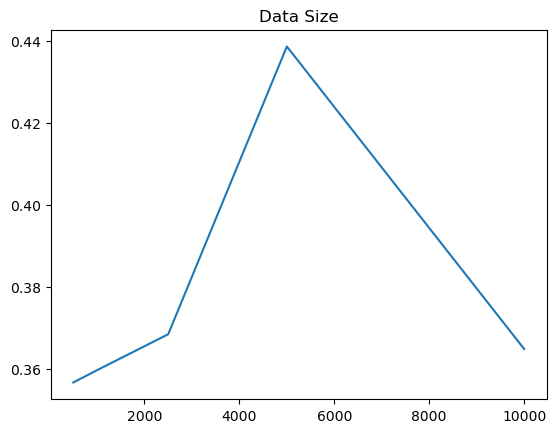

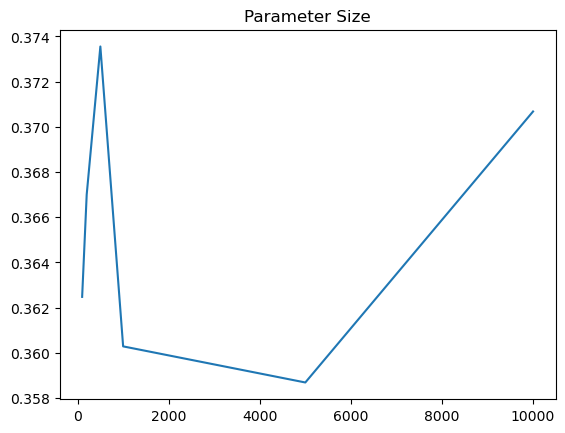

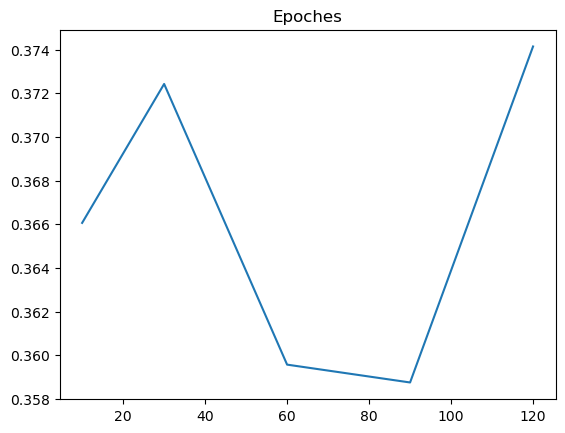

In [30]:
plt.title('Data Size')
plt.plot(sizes_arr,times_arr)
plt.show()
plt.title('Parameter Size')
plt.plot(sizep_arr,timep_arr)
plt.show()
plt.title('Epoches')
plt.plot(epoch_arr,timee_arr)
plt.show()